## 学习率搜索器
学习率查找器绘制了与学习者的损失关系。 这个想法是减少选择良好的起始学习率的猜测量。

<b>概述：</b>

1. 首先运行lr_find learn.lr_find（）
2. 绘制学习率vs loss learn.recorder.plot（）
3. 在分歧之前选择学习率然后开始训练

技术细节:(由Leslie Smith首先描述）

训练学习者几次迭代。 从一个非常低的start_lr开始，并在每个小批量更改它，直到它达到一个非常高的end_lr。 记录器将记录每次迭代的损失。 根据学习率绘制这些损失，以便在它发散之前找到最佳值。

### 选择一个好的学习率
有关更直观的解释，请查看Sylvain Gugger的帖子

In [1]:
from fastai.vision import *
from fastai.basics import *
from fastai.callbacks import *

In [2]:
path = untar_data(URLs.MNIST_SAMPLE)
data = ImageDataBunch.from_folder(path)
def simple_learner(): 
    return Learner(data, simple_cnn((3,16,16,2)), metrics=[accuracy])
learn = simple_learner()

首先，我们运行此命令以启动搜索：
<b>lr_find</b>

`lr_find(learn:Learner, start_lr:Floats=1e-07, end_lr:Floats=10, num_it:int=100, stop_div:bool=True, wd:float=None)`

在学习中通过num_it迭代从start_lr到end_lr探索lr。 如果stop_div，当损失发散时停止。

In [3]:
learn.lr_find(stop_div=False, num_it=200)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


然后我们绘制损失与学习率。 我们有兴趣找到一个很好的学习率数量级，所以我们用对数标度绘图。

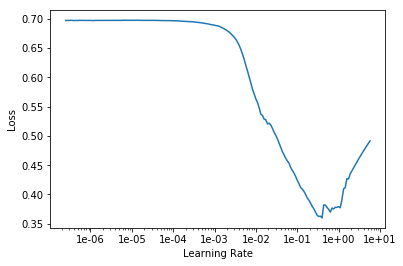

In [4]:
learn.recorder.plot()

然后，我们选择一个大约在最锐利的下坡中间的值。 这是LR Finder工具的指示，让我们试试1e-2。

In [5]:
simple_learner().fit(2, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.094117,0.063358,0.979392,00:55
1,0.053213,0.036175,0.987242,00:56


不要只从情节中选择最小值！

In [7]:
learn = simple_learner()
simple_learner().fit(2, 1e-0)

epoch,train_loss,valid_loss,accuracy,time
0,1.058446,0.693147,0.495584,00:56
1,0.700403,0.693147,0.495584,00:57


在下坡之前选择一个值会导致训练缓慢：

In [8]:
learn = simple_learner()
simple_learner().fit(2, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.153365,0.138153,0.951423,00:56
1,0.109469,0.103037,0.965653,00:56


### Suggested LR
如果您在learn.recorder.plot中传递suggestion = True，您将看到gardient是最陡峭的点
图上的红点。 我们可以将这一点用作LR的第一个猜测。

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 4.79E-03


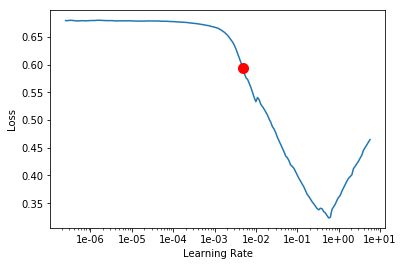

In [9]:
learn.lr_find(stop_div=False, num_it=200)
learn.recorder.plot(suggestion=True)

您可以像这样访问相应的学习率：

In [10]:
min_grad_lr = learn.recorder.min_grad_lr
min_grad_lr

0.00478630092322638

In [11]:
learn = simple_learner()
simple_learner().fit(2, min_grad_lr)

epoch,train_loss,valid_loss,accuracy,time
0,0.117535,0.093683,0.966634,00:58
1,0.072120,0.074786,0.974975,00:58


### class LRFinder
`LRFinder(learn:Learner, start_lr:float=1e-07, end_lr:float=10, num_it:int=100, stop_div:bool=True) :: LearnerCallback`

导致学习从start_lr到end_lr进行模拟训练以进行num_it迭代。

回调方法
你不要自己调用 - 他们会被fastai的Callback系统自动调用，以启用该类的功能。

<b>on_train_begin</b>

`on_train_begin(pbar, **kwargs:Any)`

初始化优化器和学习器超参数。

<b>on_batch_end</b>

`on_batch_end(iteration:int, smooth_loss:TensorOrNumber, **kwargs:Any)`

确定损失是否已经失控，我们应该停止。

<b>on_epoch_end</b>

`on_epoch_end(**kwargs:Any)`

在一个时代结束时被召唤。

<b>on_train_end</b>

`on_train_end(**kwargs:Any)`

清理学习在LRFinder探索期间受到干扰的模型权重。